# Deepdive

In `quickstart.ipynb` we look at the mainstream usage of `pyiron_workflow`, leveraging `Workflow` as a single point of access, defining custom nodes, and building computational workflows. This notebook builds on that by exploring extra tools for more specialized uses, as well as demonstrating several edge-cases and extension points. We'll try to cover not just the `Workflow` class and the tools it exposes, but everything in the "public API" exposed in `pyiron_workflow.__init__`.

The target audience here is advanced users who want to make complex workflows. We'll also lay a useful foundation for readers who want to modify the core `pyiron_workflow` infrastructure itself, although that's not our target. Nonetheless, this notebook is still not exhaustive. To go further, investigate the docstrings of the various publicly exposed tools, or dig into the test suite in the source code.

In [1]:
import pyiron_workflow as pwf

## Adding new functionality with function nodes

Let's start by exploring the three main ways of making new content using "function" nodes. 

### By dynamic class

The recommended approach is to make a new node _class_ by decorating the function with the behaviour you want:

In [2]:
@pwf.as_function_node("plus", "minus")
def MyFunctionClass(x: int = 42) -> tuple[int, int]:
    return x + 1, x - 1

MyFunctionClass.mro()[:5]

[__main__.MyFunctionClass,
 pyiron_snippets.factory._FactoryMade,
 pyiron_workflow.nodes.function.Function,
 pyiron_workflow.nodes.static_io.StaticNode,
 pyiron_workflow.node.Node]

Just like in the quickstart, we that this dynamically creates a new class in `__main__` inheriting from `Node`, and `Function`, just like we'd expect. 

The `pyiron_snippets.factory._FactoryMade` is just some magic that makes sure this dynamically-defined class is still pickleable. This is important as (unless your IO data itself in unpickleable) it lets us use not only `pickle` but also the standard `concurrent.futures.ProcessPoolExecutor` to parallelize our `pyiron_workflow` content.

Also of note here is `pyiron_workflow.nodes.static_io.StaticNode`. You should see this intermediate class in the parentage of most nodes (all of them except `Workflow` at time of writing). Nodes inheriting from this class have their IO interface defined _at the class level_. That means you have access to IO labels, type hints, and default values before ever instantiating a node! (And maybe one day ontological hints too!) You can access this information with `.preview...`

In [3]:
MyFunctionClass.preview_io()

{'inputs': {'x': (int, 42)}, 'outputs': {'plus': int, 'minus': int}}

This decorator approach is easy to read, and you can instantiate as many copies of this node as you want, so this is the recommended approach to node defintions. As usual, node input can be set by kwarg at instantiation or run time; `Function` nodes specially can also have input set as a positional argument.

In [4]:
my_func1 = MyFunctionClass(label="default_input")
my_func2 = MyFunctionClass(1, label="positional_input")
my_func2()

(2, 0)

Of course keywording a positional argument is fine

In [5]:
my_func2(x=100)

(101, 99)

### As a single instance

It's also possible we might have an existing function we want to node-ize in a one-of way, without ever keeping track of the underlying node class. We can duplicate the functionality of `MyFunctionClass` the same way for a single instance like this:

In [6]:
def my_function(x: int = 42) -> tuple[int, int]:
    return x + 1, x - 1

my_function_instance = pwf.function_node(my_function, output_labels=("plus", "minus"))

my_function_instance.__class__.mro()[:5]

[__main__.my_function,
 pyiron_snippets.factory._FactoryMade,
 pyiron_workflow.nodes.function.Function,
 pyiron_workflow.nodes.static_io.StaticNode,
 pyiron_workflow.node.Node]

Of course other than the name of the immediate class, this looks the same as before, and indeed it is

In [7]:
assert(my_function_instance.__class__.mro()[1:] == MyFunctionClass.mro()[1:])

There's no particular advantage to making a single instance instead of the typical decorator approach, it just may be slightly more convenient sometimes. In general using the decorator is suggested.

### By explicit subclass

The final path is the traditional OOP coding route of simply making a new class that inherits from `Function`. The only requirement is that it have a `staticmethod` called `node_function` which takes the place of the decorated/passed functions above. You may optionally specify an `_output_labels` property to name the outputs, otherwise they will get scraped from the function return code. This approach can be useful if you want to add some extra functionality on your nodes, e.g. plotting, data analysis -- anything useful but small and tightly coupled enough to the node that you don't feel the need to make a separate node to handle it.

In [8]:
class MySubFunction(pwf.Function):
    @staticmethod
    def node_function(x: int = 42) -> tuple[int, int]:
        return x + 1, x - 1

    _output_labels = ("plus", "minus")

    def is_bound(self, n) -> bool:
        if self.outputs.plus.value is not pwf.NOT_DATA:
            return self.outputs.plus.value > n and self.outputs.minus.value < n
        else:
            raise RuntimeError("Run the node first")

my_subfunc = MySubFunction()

try:
    my_subfunc.is_bound(33)
except RuntimeError:
    print("Maybe our method depends on having output data")

my_subfunc()
assert(my_subfunc.is_bound(42.5) and not my_subfunc.is_bound(0))

Maybe our method depends on having output data


This pattern of subclass-by-decoration, instance-by-call, or traditional subclassing are available under the same syntaxes for all three standard base classes for new nodes: `Function`, `Macro`, and `Dataclass`.

### Parsing awkward functions

`pyiron_workflow` is predecated on being able to identify and label not just the inputs of functions, but their outputs. We try to make this convenient by scraping output labels from the raw code of the return value. But, sometimes it doesn't go that easily. Sometimes you might want to wrap an existing function, maybe it even has multiple return values! Or maybe there is no raw source code because the entire function is dynamic (e.g. a lambda function). We don't offer flexible/dynamic output -- the output still needs to be fixed at the class level -- but as long as you are willing to vouch for the function you're wrapping, you can bypass restrictions on parsability of the function code. In this case, you _must_ provide explicit output labels, and you need to set a flag to indicate that parsing should not be performed. Below we show how to do this for an existing function and get a new, importable class by updating the class name:

In [9]:
def my_awkard_function(x):
    """
    Here is a function that has multiple return values, so we can't parse it by default.
    It also awkwardly sometimes returns a string, and other times returns a bool (or 
    even an array of bools if we were to pass a numpy array in!) so it is going to be 
    awkward anyhow, since we can't give a very reliable type hint for the input...

    But let's explore what we can do to get around this anyhow!
    """
    if isinstance(x, str):
        return x
    if x > 0:
        return True
    elif x < 0:
        return False

In [10]:
try:
    pwf.function_node(my_awkard_function, "some_output_label")
except ValueError:
    print(
        "We can't parse output labels, or compare if the provided ones are valid, "
        "when there are multiple `return` statements!"
    )

We can't parse output labels, or compare if the provided ones are valid, when there are multiple `return` statements!


In [11]:
JustMakeItGo = pwf.as_function_node(
    "some_label", 
    validate_output_labels=False,  # Blindly trusts the requested label(s)
)(my_awkard_function)
JustMakeItGo.__name__ = "JustMakeItGo"  

Note that we've manually set the class name to match the local variable we stored the class in. This is so we can import it correctly later if we want:

In [12]:
from __main__ import JustMakeItGo as ReimportedJMIG

assert(ReimportedJMIG is JustMakeItGo)

This node runs fine:

In [13]:
jmig = JustMakeItGo()
assert(jmig(5))

But it's is still kind of an unfriendly node, since the output type can totally change. Some cases could be even worse, imagine if different return branches returned different numbers of objects! Then sometimes we'd get a value, or other times tuples of values. What a headache. The point is you _can_ force unfriendly functions into our paradigm, but you may not _want_ to. It may be better to just write your own sanitizing wrapper function around them to expose the functionality you care about, or to just write a new function from scratch.

## Macros provide an interface to their subgraph

We have access to the same three routes for adding functionality by inheriting from `Macro` just like we do from `Function`. We learned in `quickstart.ipynb` how macros are fundamentally different from function nodes: `Function` nodes are based around _plain python functions_ and can do anything python does and do it every time the function node runs; in contrast, `Macro` nodes use the `pyiron_workflow` framework to _define a graph_, they do it _once at instantiation_, and from then on running the node executes that subgraph. That means you can still write regular python inside your macro definition, but (with the exception of operations that work on data channels via node injection) you can't use that python to process input data and manipulate it because it is (a) acting on data channels not the underlying data held by those channels, and (b) happens only once to the initial data!

None of that should be a shock, but here we'll look at _how_ macro nodes accomplish this. First, let's make a couple of trivially simple nodes with which to demo functionality:

In [14]:
@pwf.as_function_node
def TimesTwo(x: int) -> int:
    twox = 2 * x
    return twox

@pwf.as_macro_node
def TwoCubed(self, x: int) -> int:
    self.two = TimesTwo(x)
    self.four = TimesTwo(self.two)
    self.eight = TimesTwo(self.four)
    return self.eight

### No outside connections

Macros define an explicit interface between the subgraph they hold and the outside world, that means you can't use data (or signal) connections directly between macro child nodes and other nodes. At time of writing, you will be permitted to _form_ the connections, but will get a relatively clear error if you try to actually leverage them.

This is the case whether you're working directly with nodes:

In [15]:
non_child = TimesTwo(label="non_child")
macro = TwoCubed(2, label="macro")

non_child.inputs.x = macro.four.outputs.twox

try:
    non_child()
except ValueError as e:
    print("ValueError:", e)

ValueError: Nodes in a data digraph must all be siblings -- i.e. have the same `parent` attribute. Some of these do not: /non_child5141248272
/macro/two5141400464
/macro/four5141296976


Or whether they're packaged in a workflow:

In [16]:
wf = pwf.Workflow("walled_gardens")
wf.non_child = TimesTwo()
wf.macro = TwoCubed(2)
wf.non_child.inputs.x = wf.macro.four.outputs.twox

try:
    wf()
except KeyError as e:
    print("KeyError:", e)

KeyError: 'The channel /walled_gardens/non_child.x has a connection to the upstream channel /walled_gardens/macro/four.twox, but the upstream owner four was not found among nodes. All nodes in the data flow dependency tree must be included.'


### Value syncing

The prohibition against outside connections guarantees that the macro doesn't receive outside interference, but then how _does_ the macro communicate outside information in and inside information back out?

In addition to the regular "connections" data and signal channels have, data channels also quietly have a `.value_receiver` method. These guarantee that whenever the value of that channel is updated, the new value is immediately propagated to its receiving partner. Macro's use this for input:

In [17]:
assert(macro.inputs.x is not macro.two.inputs.x)
assert(macro.inputs.x.value_receiver is macro.two.inputs.x)

print(macro.inputs.x.value, macro.two.inputs.x.value)
macro.inputs.x.value = 5
print(macro.inputs.x.value, macro.two.inputs.x.value)

2 2
5 5


And output:

In [18]:
assert(macro.eight.outputs.twox is not macro.outputs.eight)
assert(macro.eight.outputs.twox.value_receiver is macro.outputs.eight)

print(macro.eight.outputs.twox.value, macro.outputs.eight.value)
macro.eight.outputs.twox.value = 5
print(macro.eight.outputs.twox.value, macro.outputs.eight.value)

NOT_DATA NOT_DATA
5 5


### Dynamic input forking

Each data channel can have at most one `.value_receiver`, but sometimes our macro input gets sent to more than one child! To accommodate this, under the hood, macros are dynamically creating new nodes to hold input, then pruning these at the end of the macro instantiation if they are unnecessary. In the example below we can see that, at instantiation time, the macro has a new `pyiron_workflow.nodes.standard.UserInput` for both its inputs; for the forked input (`x`) this node persists as a child and is the on the receiving end of the macro input, but for the input with a single recipient (`y`) the intermediate node can be pruned and the macro input is fed straight to the node explicitly created in the macro definition:

In [19]:
@pwf.as_macro_node
def VerboseFork(self, x: int, y: int) -> tuple[int, int, int]:
    print(type(x))
    print(type(y))
    self.pair1 = TimesTwo(x)
    self.pair2 = TimesTwo(x)
    self.alone = TimesTwo(y)
    return self.pair1, self.pair2, self.alone

m = VerboseFork()
print(m.child_labels)  # Includes a "forking" input child not in the definition!

assert(m.inputs.x.value_receiver is m.x.inputs.user_input)
assert(m.inputs.y.value_receiver is m.alone.inputs.x)

<class 'pyiron_workflow.nodes.standard.UserInput'>
<class 'pyiron_workflow.nodes.standard.UserInput'>
('x', 'pair1', 'pair2', 'alone')


### Node injection and macro definitions

We saw in the `quickstart.ipynb` how nodes returning only a single value can be operated on as though you were operating on their (only) data output channel, and how data output channels can be operated on to dynamically create new nodes to (delay and) perform the operation. 

We have also discussed how we mustn't mix-and-match raw python data processing we do in `Function` definitions with the graph setup we do in `Macro` definitions.

Here, let's just quickly revisit this concept to show how we can sometimes leverage node injection to do some fairly complex processing of data in a macro after all. We have most but not all operators at our disposal -- some, like `>>` and `<<` bitshift operators are reserved to have actual meaning within the `pyiron_workflow` framework -- as well as a number of extra methods, e.g. `.eq` since we want to reserve `==` for its totally regular meaning and not inject on it.

In [20]:
from types import FunctionType
from pyiron_workflow.mixin.injection import OutputDataWithInjection

for k, v in OutputDataWithInjection.__dict__.items():
    if (
        isinstance(v, FunctionType) 
        and k not in ["__init__", "_get_injection_label", "_node_injection"]
    ):
        print(k, v)

__getattr__ <function OutputDataWithInjection.__getattr__ at 0x1325e62a0>
__getitem__ <function OutputDataWithInjection.__getitem__ at 0x1325e6340>
__lt__ <function OutputDataWithInjection.__lt__ at 0x1325e63e0>
__le__ <function OutputDataWithInjection.__le__ at 0x1325e6480>
eq <function OutputDataWithInjection.eq at 0x1325e6520>
__ne__ <function OutputDataWithInjection.__ne__ at 0x1325e65c0>
__gt__ <function OutputDataWithInjection.__gt__ at 0x1325e6660>
__ge__ <function OutputDataWithInjection.__ge__ at 0x1325e6700>
bool <function OutputDataWithInjection.bool at 0x1325e67a0>
len <function OutputDataWithInjection.len at 0x1325e6840>
contains <function OutputDataWithInjection.contains at 0x1325e68e0>
__add__ <function OutputDataWithInjection.__add__ at 0x1325e6980>
__sub__ <function OutputDataWithInjection.__sub__ at 0x1325e6a20>
__mul__ <function OutputDataWithInjection.__mul__ at 0x1325e6ac0>
__rmul__ <function OutputDataWithInjection.__rmul__ at 0x1325e6b60>
__matmul__ <function Out

In [21]:
@pwf.as_macro_node
def TheFifthElement(
    self,
    exactly_five: tuple[int, int, int, int, int], 
    mod: int = 10, 
    extra: int = 5,
    target: int = 0,
) -> tuple[bool, float]:
    self.fifth_element = exactly_five[4]  # Access injection
    self.transformed = (self.fifth_element + extra) % mod  # Operator injection
    self.matches = self.transformed.eq(target)  # Method injection
    as_float = self.transformed.float()
    return self.matches, as_float

five = TheFifthElement((1, 2, 3, 4, 5))
for n in five:
    print(f"{n.label} <{n.__class__.__name__}>")
five()

fifth_element <GetItem>
injected_Add_m2897328808919832336 <Add>
transformed <Modulo>
matches <Equals>
injected_Float_m2597644581695605976 <Float>


{'matches': True, 'as_float': 0.0}

It's always valid to extract your data processing as its own `Function` node and then use that, but we see here there is a reasonable amount of flexibility by leveraging injection. Most of our injected nodes were immediately assigned to an attribute of our macro (and thus re-labeled), but the `(self.fifth_element + extra)` was only ever used in-line and so retains its automatically-generated label. This is also true for `as_float`, which appears only as a local variable -- the variable name is still scraped for the purpose of naming the macro output channel, but the node itself retains its generated label.

As a counter-example, we couldn't have written `as_float = float(self.transformed)`, because `self.transformed` (and `exactly_five`, `mod`, `extra`, `target`, and all the other child nodes) are _nodes_ (or output channels) and taking the "float" of this nonsensicle! The `.float()` method defined on the injection class gives explicit instruction to generate a new node to handle this transformation on the data values in a delayed manner. We try to add enough such injections to cover your day-to-day needs, but where that fails you simply need to write and use your own node.

## Dataclass nodes for grouping inputs

The last of the standard approaches for new node functionality is `DataclassNode`. They're a little bit different in that the underlying definition is a class (if it isn't already a `@dataclasses.dataclass` it will be wrapped as one), but otherwise the three standard approaches for making new ones work exactly as for `Macro` and `Function`.

Like usual dataclasses, these are for packaging groups of input together into sensible packages, and even allow inheritance for composing together input from different places. The dataclass itself gets stored on the `.dataclass` class attribute of the node class.

In [22]:
@pwf.as_dataclass_node
class Car:
    color: str
    doors: int
    wheels: int = 4

@pwf.as_dataclass_node
class Coupe(Car.dataclass):
    doors: int = 2
    spoiler: bool = False

# Note: Inheritance with dataclasses can be tricky, particularly with regards to the order of 
# default and non-default parameters. In general, composition is preferable over inheritance and 
# extension. So this example is somewhat questionable python, but we're just trying to show 
# some `DataclassNode` syntax, so don't sweat it.

Coupe.preview_io()

{'inputs': {'color': (str, NOT_DATA),
  'doors': (int, 2),
  'wheels': (int, 4),
  'spoiler': (bool, False)},
 'outputs': {'dataclass': __main__.Coupe.dataclass}}

We can then leverage the dataclass node as an entry point for users to specify data, and write business logic that accepts the entire dataclass as IO:

In [23]:
@pwf.as_function_node("repainted")
def Repaint(car: Car.dataclass, new_color: str):
    car.color = new_color
    return car

@pwf.as_function_node
def SpeedingTicket(car: Car.dataclass):
    ticket = 100
    if car.color.lower() == "red":
        # Red cars go faster, everyone knows
        ticket += 50
    if car.doors < 4:
        # Too sporty looking, eh
        ticket += 30
    return ticket

wf = pwf.Workflow("a_tale_of_two_tickets")
wf.car = Coupe(color="green")
wf.red_car = Repaint(wf.car, "RED")
wf.ticket = SpeedingTicket(wf.car)
wf.red_ticket = SpeedingTicket(wf.red_car)
wf()

{'ticket__ticket': 130, 'red_ticket__ticket': 180}

## Disabling type hints

By default, `pyiron_workflow` is strongly hinted, so you can't pass wrongly-typed values or from incompatibly-hinted connections:

In [24]:
repainted = Repaint()
repainted.inputs.new_color = "light urple"
try:
    repainted.inputs.car = "a_string_not_a_Car"
except TypeError as e:
    print("TypeError:", e)

TypeError: The channel /Repaint.car cannot take the value `a_string_not_a_Car` (<class 'str'>) because it is not compliant with the type hint <class '__main__.Car.dataclass'>


You can forcably disable this, either for a specific channel or at the node-level for all channels:

In [25]:
repainted = Repaint()
repainted.inputs.new_color = "light urple"

repainted.deactivate_strict_hints()
repainted.inputs.car = "a_string_not_a_Car"

But, at least in this example, it's not a good idea...

In [26]:
try:
    repainted.run()
except AttributeError as e:
    print("AttributeError:", e)

AttributeError: 'str' object has no attribute 'color'


## Other transformers

`DataclassNode` is an example of a "transformer" -- a simple tool for converting input to a particular form of output via a node. There are several others, but they are so simple that there is not much flexibility in instantiating them, just use the "meta" node to make a new class and new instance at once.

Here we just demo them so you know they exist

In [27]:
i2df = pwf.inputs_to_dataframe(3)

i2df(
    row_0 = {"strings": "a", "ints": 1, "types": int},
    row_1 = {"strings": "b", "ints": 2, "types": float},
    row_2 = {"strings": "c", "ints": 3, "types": str},
)

,strings,ints,types
0,a,1,<class 'int'>
1,b,2,<class 'float'>
2,c,3,<class 'str'>


In [28]:
i2d = pwf.inputs_to_dict(
    input_specification={
        "x": (None, pwf.NOT_DATA),
        "y": (int, 42)
    }
)
print(i2d.preview_io())
i2d("foobar")

{'inputs': {'x': (None, NOT_DATA), 'y': (<class 'int'>, 42)}, 'outputs': {'dict': <class 'dict'>}}


{'x': 'foobar', 'y': 42}

In [29]:
i2l = pwf.inputs_to_list(5)
i2l(1, 2, 3, "four", "five")

[1, 2, 3, 'four', 'five']

In [30]:
l2o = pwf.list_to_outputs(5)
l2o(i2l)

{'item_0': 1, 'item_1': 2, 'item_2': 3, 'item_3': 'four', 'item_4': 'five'}

## Workflows

Workflows are the main interface point for `pyiron_workflow`, and already discussed in the `quickstart.ipynb`.

### Workflow IO

It bears re-iterating that they differ from all the other nodes we've talked about so far in that their IO _is not static_. It is mutable and varies with the contents of their children. In fact, it gets re-created at each access! And unlike `Macro` nodes, which act as a walled garden, `Workflow` is really giving direct access to the underlying child IO channels:

In [31]:
wf = pwf.Workflow("no_wall")
wf.child = pwf.standard_nodes.UserInput()

assert(wf.inputs.child__user_input is wf.child.inputs.user_input)

If we really want to, we can break the traditional format of `f"{child.label}__{channel.label}"` for workflow IO and give it explicit names. Care should be taken that since workflows are mutable, the map may become invalid if the children of the workflow change.

In [32]:
wf.inputs_map = {"child__user_input": "inp"}
wf.outputs_map = {"child__user_input": "out"}

wf(inp="some data")

{'out': 'some data'}

### Modifying contents

Another way to add a child is to assign the workflow as a parent at instantiation:

In [33]:
pwf.standard_nodes.UserInput(parent=wf)
wf.child_labels

('child', 'UserInput')

The key difference between these is that in the latter case, the child node finds out it is a child of the workflow _at instantiation_, while assigning a node to the workflow first fully instantiates it (with some default label, like we see above) and then parents it to the workflow and updates its label according to the workflow attribute name we're using.

You can also invoke the `add_child` method to add a node instance as a child directly. If we try this naively, we'll see that the automated name will conflict with an existing child that also used its automated name:

In [34]:
try:
    wf.add_child(pwf.standard_nodes.UserInput())
except AttributeError as e:
    print("AttributeError:", e)

AttributeError: UserInput is already the label for a child. Please remove it before assigning another child to this label.


We could give the child a different name, or we can just allow the workflow to dynamically re-name conflicts:

In [35]:
wf.strict_naming = False
wf.add_child(pwf.standard_nodes.UserInput())
wf.child_labels

('child', 'UserInput', 'UserInput0')

In a similar way we can remove children by name

In [36]:
wf.remove_child("child")
wf.child_labels

('UserInput', 'UserInput0')

or by instance

In [37]:
wf.remove_child(wf.UserInput)
wf.child_labels

('UserInput0',)

We can also replace children, with the caveat that the replacement must have commensurate IO with what is being replaced

In [38]:
replacement = pwf.standard_nodes.UserInput(42)

print(wf.UserInput0.inputs.user_input.value)
wf.replace_child(wf.UserInput0, replacement)
print(wf.UserInput0.inputs.user_input.value)

NOT_DATA
42


### Dictionary representation

You can get a simple dictionary representation of a given workflow (or macro) with a `'nodes'` subdictionary linking full labels to node instances, and an `'edges'` dictionary further decomposed into `'data'` and `'signals'` that use tuples of full labels as keys for tuples of (output, input) channel instances:

In [39]:
wf = pwf.Workflow("graph_as_dict")
wf.inp = pwf.standard_nodes.UserInput(42)
wf.a = wf.inp + 2
wf.b = wf.inp + 4
wf.out = wf.a * wf.b
wf.graph_as_dict

{'nodes': {'/graph_as_dict/inp': <pyiron_workflow.nodes.standard.UserInput at 0x1098a19d0>,
  '/graph_as_dict/a': <pyiron_workflow.nodes.standard.Add at 0x1326fcfd0>,
  '/graph_as_dict/b': <pyiron_workflow.nodes.standard.Add at 0x1327b3550>,
  '/graph_as_dict/out': <pyiron_workflow.nodes.standard.Multiply at 0x1326d7c90>},
 'edges': {'data': {('/graph_as_dict/inp.user_input',
    '/graph_as_dict/b.obj'): (<pyiron_workflow.mixin.injection.OutputDataWithInjection at 0x131a2f4d0>,
    <pyiron_workflow.channels.InputData at 0x1327b3890>),
   ('/graph_as_dict/inp.user_input',
    '/graph_as_dict/a.obj'): (<pyiron_workflow.mixin.injection.OutputDataWithInjection at 0x131a2f4d0>, <pyiron_workflow.channels.InputData at 0x1327af490>),
   ('/graph_as_dict/a.add',
    '/graph_as_dict/out.obj'): (<pyiron_workflow.mixin.injection.OutputDataWithInjection at 0x1327ad110>, <pyiron_workflow.channels.InputData at 0x1326e81d0>),
   ('/graph_as_dict/b.add',
    '/graph_as_dict/out.other'): (<pyiron_workfl

### Signal flow is created at runtime

Just like the IO for a workflow is created at runtime, unless automatic execution is explicitly disabled, the execution signals are empty until a run is triggered. This is why the `'signals'` sub-dictionary above is empty. We can create them from the DAG data flow with a run call:

In [40]:
wf()
for (ran, run) in wf.graph_as_dict["edges"]["signal"].keys():
    print(ran, "-->", run)

/graph_as_dict/inp.ran --> /graph_as_dict/b.accumulate_and_run
/graph_as_dict/inp.ran --> /graph_as_dict/a.accumulate_and_run
/graph_as_dict/a.ran --> /graph_as_dict/out.accumulate_and_run
/graph_as_dict/b.ran --> /graph_as_dict/out.accumulate_and_run


## `NOT_DATA` because `None` is real

You will notice that the default value for node input is `NOT_DATA`. This is because `None` is a real and valid input for many functions, e.g. instead of having a mutable input a function might have `some_list_input = [] if some_list_input is None else some_list_input`. `NOT_DATA` is our way of not stepping on the toes of such uses of `None`.

There's not a lot to this, except to note that `NOT_DATA` is a "singleton", so all its occurrences will pass an "is" test:

In [41]:
assert(pwf.standard_nodes.UserInput().inputs.user_input.value is pwf.NOT_DATA)

## Connection ordering and priority

When a node runs, it tries to get data by going through its input connections and using the first connection that holds data _other_ than `NOT_DATA`, using its current value (e.g. a default) if none satisfy this. More recent connections are placed higher in the connection list

In [42]:
source1 = pwf.standard_nodes.UserInput(label="source1")
source2 = pwf.standard_nodes.UserInput(label="source2")
source3 = pwf.standard_nodes.UserInput(label="source3")
receiver = pwf.standard_nodes.UserInput(42)

receiver.inputs.user_input = source3
receiver.inputs.user_input = source2
receiver.inputs.user_input = source1
print([c.owner.label for c in receiver.inputs.user_input.connections])
receiver.run(run_data_tree=False)

['source1', 'source2', 'source3']


42

In [43]:
source2(100)  # Populate source2 output
receiver.run(run_data_tree=False)

100

In [44]:
source1(0)  # Populate source1 output
receiver.run(run_data_tree=False)

0

## Caching

By default, all nodes exploit caching. I.e. when they run they save a fresh dictionary of their input values; in all subsequent runs if the dictionary of their current input values matches (`==`) that last-used dictionary, they skip executing altogether and leverage their existing outputs.

Any changes to the inputs will obviously stop the cache from being retrieved, but for `Composite` nodes it is also reset if any child nodes are added/removed/replaced.

Note that since we do a simple `==` on the dictionary of input values, if your workflow non-idempotently passes around mutable data, it's possible you'll wind up in a situation where you get a false cache hit.

Caching behaviour can be defined at the class-level as a default, but can be overridden for individual nodes. Let's take a look:

In [45]:
import random 

@pwf.as_function_node(use_cache=False)
def Randint(low=0, high=999):
    rand = random.randint(low, high)
    return rand

wf = pwf.Workflow("mixed_caching")
wf.use_cache = False  # Turn _off_ caching for the whole workflow!

wf.always_new = Randint()
wf.cached = Randint()
wf.cached.use_cache = True  # Turn _on_ caching for this node

wf()

{'always_new__rand': 147, 'cached__rand': 45}

Running the same workflow again, we see that the cached node just keeps returning the same "random" number, while the un-cached node gives us something new

In [46]:
wf()

{'always_new__rand': 821, 'cached__rand': 45}

If we look into the caching data, we can see that the non-caching node has not stored any inputs and does not register a cache hit; even if we had previously cached something, if we switch to `use_cache = False`, we won't even look for the cache hit but will just give new data!

In [47]:
for node in wf:
    print(node.label, node.inputs.to_value_dict(), node.cached_inputs, node.cache_hit)

always_new {'low': 0, 'high': 999} None False
cached {'low': 0, 'high': 999} {'low': 0, 'high': 999} True


## Mutability

In `pyiron_workflow` it's a best-practice to make your nodes functional and idempotent -- i.e. they should not mutate mutable input data! This is python, so we're not going to stop you from doing it, and maybe you'll hit a situation where you really need to...but it's not recommended.

Here we'll show a concrete example of what happens when you mutate data, and how this can interact with caching to wind up skipping things you think you should be running.

In [48]:
@pwf.as_function_node
def SayMyName(name: str, collection: list[str]) -> tuple[str, list[str]]:
    collection.append(name)
    my_name_is = f"My name is {name}, and I've collected {collection}"
    print(my_name_is)
    return my_name_is, collection

wf = pwf.Workflow("mutable_trouble")
wf.a = SayMyName("Alice", [])
wf.b = SayMyName("Bob", wf.a.outputs.collection)
wf.c = SayMyName("Chandy", wf.b.outputs.collection)
wf.d = SayMyName("Deng", wf.c.outputs.collection)
wf()

My name is Alice, and I've collected ['Alice']
My name is Bob, and I've collected ['Alice', 'Bob']
My name is Chandy, and I've collected ['Alice', 'Bob', 'Chandy']
My name is Deng, and I've collected ['Alice', 'Bob', 'Chandy', 'Deng']


{'a__my_name_is': "My name is Alice, and I've collected ['Alice']",
 'b__my_name_is': "My name is Bob, and I've collected ['Alice', 'Bob']",
 'c__my_name_is': "My name is Chandy, and I've collected ['Alice', 'Bob', 'Chandy']",
 'd__my_name_is': "My name is Deng, and I've collected ['Alice', 'Bob', 'Chandy', 'Deng']",
 'd__collection': ['Alice', 'Bob', 'Chandy', 'Deng']}

So far everything looks good... but beneath the water trouble is lurking! Our mutable `collection` list is input for _all_ our nodes! That means the "functional" contract that the current output of a node corresponds to what it will return if it is run with its current input:

In [49]:
wf.a.inputs.to_value_dict()

{'name': 'Alice', 'collection': ['Alice', 'Bob', 'Chandy', 'Deng']}

In [50]:
wf.a.outputs.to_value_dict()

{'my_name_is': "My name is Alice, and I've collected ['Alice']",
 'collection': ['Alice', 'Bob', 'Chandy', 'Deng']}

It is painfully obvious that the immutable `'my_name_is'` result doesn't correspond to the alleged input, but the `'collection'` doesn't either as the _last_ element should be `'Alice'` regardless of what collection was passed in.

This effect also impacts the caching, since the _cached_ inputs are also subject to mutability!

In [51]:
wf.a.cached_inputs

{'name': 'Alice', 'collection': ['Alice', 'Bob', 'Chandy', 'Deng']}

Thus, we're going to encounter the `inputs == cached_inputs` whether we want it or not, so if we try to re-run the workflow nothing will happen:

In [52]:
wf()

{'a__my_name_is': "My name is Alice, and I've collected ['Alice']",
 'b__my_name_is': "My name is Bob, and I've collected ['Alice', 'Bob']",
 'c__my_name_is': "My name is Chandy, and I've collected ['Alice', 'Bob', 'Chandy']",
 'd__my_name_is': "My name is Deng, and I've collected ['Alice', 'Bob', 'Chandy', 'Deng']",
 'd__collection': ['Alice', 'Bob', 'Chandy', 'Deng']}

As seen in the caching section, we can disable caching altogether to force the workflow to re-run, despite its mutable data:

In [53]:
for n in wf:
    n.use_cache = False
wf()

{'a__my_name_is': "My name is Alice, and I've collected ['Alice']",
 'b__my_name_is': "My name is Bob, and I've collected ['Alice', 'Bob']",
 'c__my_name_is': "My name is Chandy, and I've collected ['Alice', 'Bob', 'Chandy']",
 'd__my_name_is': "My name is Deng, and I've collected ['Alice', 'Bob', 'Chandy', 'Deng']",
 'd__collection': ['Alice', 'Bob', 'Chandy', 'Deng']}

## Flow control

Workflows and macros automatically generate execution signal connections based on the topology of the data flow (once at instantiation for macros, and at each run for workflows). This is possible if and only if the data flow forms a directed acyclic graph (DAG). It's possible you may want to impose a particular execution order even when there is no direct data dependence between two nodes (although this is a bit of a code smell, and you should seriously ask _should_ these nodes have a data dependence?)

Under the hood, when each node finishes running, it fires off all the signals in its `emitting_channels` property. Typically this is just `ran`, but the standard library `If` node shows an example of how this can be extended:

In [54]:
pwf.standard_nodes.If.emitting_channels??

Type:        property
String form: <property object at 0x1098ad3f0>
Source:     
# pwf.standard_nodes.If.emitting_channels.fget
@property
def emitting_channels(self) -> tuple[OutputSignal]:
    if self.outputs.truth.value:
        return (*super().emitting_channels, self.signals.output.true)
    else:
        return (*super().emitting_channels, self.signals.output.false)

These output signal channels can be connected to input signal channels which trigger functions on their owner -- a `run` command for the default input signal channels. This can happen directly (when unparented nodes are connected) or by the mediation of a parent (if the nodes belong to a workflow or macro).

The two standard input signals are `run`, which triggers a run whenever _any_ of its connections emits, or `accumulate_and_run`, which triggers a run after _all_ of its connections have emitted at least once:

In [55]:
@pwf.as_function_node
def Verbose(x, y, z):
    print(x, y, z)
    return z

wf = pwf.Workflow("run_control")
wf.start = Verbose("", "", "start")
wf.immediate = Verbose(wf.start, "", "immediate")
wf.collecting = Verbose(wf.start, wf.immediate, "collecting")

wf.immediate.signals.input.run = wf.start.signals.output.ran
wf.collecting.signals.input.accumulate_and_run = wf.start.signals.output.ran
wf.collecting.signals.input.accumulate_and_run = wf.immediate.signals.output.ran

wf.starting_nodes = [wf.start]

# If _any_ signals are manually set, then _all_ signals and starting nodes must be set
# There is no mixing and matching

wf.automate_execution = False  # This flag is needed only for Workflows, but not in Macro definitions

wf()

  start
start  immediate
start immediate collecting


{'collecting__z': 'collecting'}

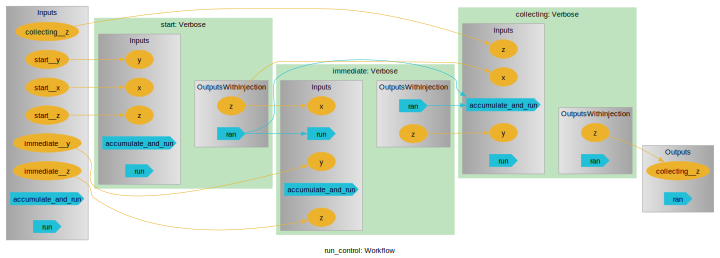

In [56]:
wf.draw(size=(10, 10))

The same signals can be wired with the following syntactic sugar (and the `>>` can be chained together):

In [57]:
wf = pwf.Workflow("sugar", automate_execution=False)
wf.start = Verbose("", "", "start")
wf.immediate = Verbose(wf.start, "", "immediate")
wf.collecting = Verbose(wf.start, wf.immediate, "collecting")

wf.start >> wf.immediate
wf.collecting << (wf.start, wf.immediate)

wf.starting_nodes = [wf.start]

wf()

  start
start  immediate
start immediate collecting


{'collecting__z': 'collecting'}

## State behavior and the executor motivation

If we look at the `__getstate__` of a child, we will notice its parent has been purged:

In [58]:
wf.immediate.__getstate__()

{'_label': 'immediate',
 '_parent': None,
 '_signals': <pyiron_workflow.io.Signals at 0x132803350>,
 'running': False,
 'failed': False,
 'executor': None,
 'future': None,
 '_thread_pool_sleep_time': 1e-06,
 'checkpoint': None,
 'cached_inputs': {'x': 'start', 'y': '', 'z': 'immediate'},
 '_user_data': {},
 '_inputs': <pyiron_workflow.io.Inputs at 0x13274c590>,
 '_outputs': <pyiron_workflow.mixin.injection.OutputsWithInjection at 0x13274f710>}

And similarly the node's connections get purged:

In [59]:
wf.immediate.inputs.__getstate__()

{'channel_dict': {'x': <pyiron_workflow.channels.InputData at 0x132801f90>,
  'y': <pyiron_workflow.channels.InputData at 0x132803f10>,
  'z': <pyiron_workflow.channels.InputData at 0x13274f510>}}

But we see that the parent node retains state about both its children and their connections

In [60]:
parent_state = wf.__getstate__()
parent_state["start"], parent_state["_child_data_connections"]

(<__main__.Verbose at 0x1328040d0>,
 [(('immediate', 'x'), ('start', 'z')),
  (('collecting', 'x'), ('start', 'z')),
  (('collecting', 'y'), ('immediate', 'z'))])

This is actually some important engineering. Sending a node off to a parallel process with an executor requires serializing data to send to the new process. For `concurrent.futures.ProcessPoolExecutor` and those compliant with it (our expectation for these circumstances) that involves using `__getstate__` (well, `__reduce__`, but the state comes out under the hood). When we send a `Function` node off for parallel execution, we actually only send the `Function.node_function` (remember it is a `@staticmethod`!!!) and the actual input data. But for `Macro` nodes, we necessarily send the entire node so there is something there to run the subgraph! If we sent the macro's parent along, or its connections, we'd need to serialize _the entire graph_ when we run just one piece on a separate process!

This careful management of state minimizes how much data we actually need to serialize 

## Executor limitations

In a similar manner, there are some things we can't serialize, namely thread locks and other executor-related objects. That means that, at present, you can't _nest_ executors. The motivated reader can see that there is room to extend this, e.g. by accepting a node _class_ (which is serializable) and some arguments for it and recreating one on-the-fly:

In [61]:
from pyiron_workflow.mixin.run import Runnable

Runnable._parse_executor??

Signature: Runnable._parse_executor(executor) -> 'StdLibExecutor'
Source:   
    @staticmethod
    def _parse_executor(executor) -> StdLibExecutor:
        """
        We may want to allow users to specify how to build an executor rather than
        actually providing an executor instance -- so here we can interpret these.

        NOTE:
            `concurrent.futures.Executor` _won't_ actually work, because we need
            stuff with :mod:`cloudpickle` support. We're leaning on this for a guaranteed
            interface (has `submit` and returns a `Future`), and leaving it to the user
            to provide an executor that will actually work!!!

        NOTE:
            If, in the future, this parser is extended to instantiate new executors from
            instructions, these new instances may not be caught by the
            `executor_shutdown` method. This will require some re-engineering to make
            sure we don't have dangling executors.
        """
        if isi

## While loops

While-loops involve some circular flow of data that terminates on a particular data condition. These _require_ manual specification of the execution signals, as data signals alone are not enough to resolve the oroborous of flow. Thankfully, by virtue of `Macro` nodes being walled gardens, once you have encapsulated your while-behaviour inside a macro, that macro can be embedded in a usual data DAG and the parent-level execution flow can be automated as usual.

We don't have the same helper interfaces for "while" loops as we do for "for" loops discussed in the `quickstart.ipynb`, but thankfully they can just be constructed as a macro definition out of existing tools. The only "magic" piece we haven't discussed yet is the standard library `If` node -- the curious reader can go look at its definition, but basically it just has extra output signals other than `ran` which fire depending on the truthiness of its input condition. Otherwise we will use tools we've seen before. 

In the example below, we follow a pattern of breaking the while loop into `body`, `condition`, and `switch` nodes (and `history` for some state logging). This pattern can be generically followed, but the exact data connections formed between your `body` and `conditon` nodes will depend on the details of what your while-loop body is doing and what the break conditions are:

In [62]:
@pwf.as_macro_node("greater")
def AddWhileLessThan(self, a, b, cap):
    """
    Add :param:`b` to :param:`a` while the sum is less than or equal to :param:`cap`.

    A simple but complete demonstrator for how to construct cyclic flows, including
    logging key outputs during the loop.
    """
    # Bespoke logic
    self.body = pwf.standard_nodes.Add(obj=a, other=b)
    self.body.inputs.obj = self.body.outputs.add  # Higher priority connection
    # The output is NOT_DATA on the first pass and `a` gets used, 
    # But after that the node will find and use its own output
    self.condition = pwf.standard_nodes.LessThan(self.body, cap)

    # Universal logic
    self.switch = pwf.standard_nodes.If()
    self.switch.inputs.condition = self.condition

    self.starting_nodes = [self.body]
    self.body >> self.condition >> self.switch
    self.switch.signals.output.true >> self.body

    # Bespoke logging
    self.history = pwf.standard_nodes.AppendToList()
    self.history.inputs.existing = self.history
    self.history.inputs.new_element = self.body
    self.body >> self.history

    # Returns are pretty universal for single-value body nodes,
    # assuming a log of the history is not desired as output,
    # but in general return values are also bespoke
    return self.body

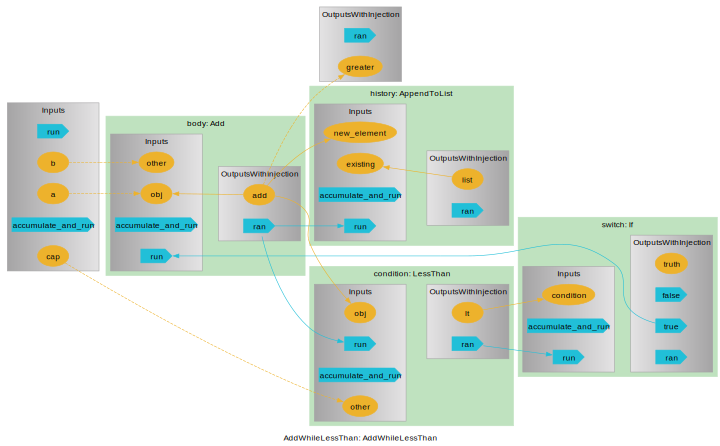

In [63]:
cyclic = AddWhileLessThan()
cyclic.draw(size=(10, 10))

In [64]:
cyclic(0, 2, 5)

{'greater': 6}

We can examine the provenance as usual. In this case, because the graph is cyclic, the same node appears multiple times

In [65]:
cyclic.provenance_by_execution

['body',
 'history',
 'condition',
 'switch',
 'body',
 'history',
 'condition',
 'switch',
 'body',
 'history',
 'condition',
 'switch']

Since the nodes only store their instantaneous IO state and not its history, we've added a "history" node into the workflow. It's not part of the macro output in this example, but you can always dig into the node to examine its state

In [66]:
cyclic.history.outputs.list.value

[2, 4, 6]

And, of course, such a macro can be (un)pickled as usual

In [67]:
import pickle

reloaded = pickle.loads(pickle.dumps(cyclic))
reloaded.outputs.greater.value

6

## Storage interfaces

We saw in `quickstart.ipynb` how to save and load nodes to/from their default location (based on the current working directory and their semantic label), and how to use checkpointing and autoloading with the built-in `"pickle"` storage back end.

We can also save and load using an explicit storage interface instance. This allows us to save and load at non-standard locations:

In [68]:
wf = pwf.Workflow("custom_save_location")
wf.cant_spell = pwf.standard_nodes.UserInput("slaughter")
wf.without = wf.cant_spell.contains("laughter")
wf()

{'without__in': True}

In [69]:
storage = pwf.PickleStorage()
storage.save(wf, "../someplace_else")

In [70]:
reloaded = storage.load(filename="../someplace_else")
assert(reloaded.outputs.without__in.value == wf.outputs.without__in.value)

And also to specify interface settings -- these can also be set on a per-operation level using kwargs, but for something like `checkpoint` the operations happen in a built-in way where we don't have the ability to modify the kwargs to the call, so we need to adjust the settings right in the interface.

For `PickleStorage` the only setting is whether to allow a fallback to `cloudpickle`, so let's turn that off and construct an example where we'd see the failure:

In [71]:
def outer_function():
    def inner_function(x):
        return x
    return inner_function

In [72]:
wf = pwf.Workflow("doomed")
wf.unpickleable = pwf.function_node(outer_function())
wf(unpickleable__x=2)

{'unpickleable__x': 2}

There's nothing inherently wrong with the node and it runs fine, but the function comes from a `<local>` scope, so we won't be able to pickle it

In [73]:
no_fallback = pwf.PickleStorage(cloudpickle_fallback=False)
wf.unpickleable.checkpoint = no_fallback
try:
    wf(unpickleable__x=3)
except pwf.TypeNotFoundError as e:
    print("TypeNotFoundError:", e)

TypeNotFoundError: doomed cannot be saved with the storage interface PickleStorage because it (or one of its children) has a type that cannot be imported. Is this node defined inside <locals>? 
Import readiness report: 
doomed: NOT IMPORTABLE
	unpickleable: NOT IMPORTABLE


### Extensions

The pickle interface inherits from a more generic `StorageInterface`, which uses abstract methods to specify what `Node` expects from an interface that sits between itself and a serialization routine. Further storage backends are possible by subclassing this base class.